In [ ]:
%autosave 300
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
os.chdir("/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/ERAV2_Advanced_VisionTransformers")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/ERAV2_Advanced_VisionTransformers


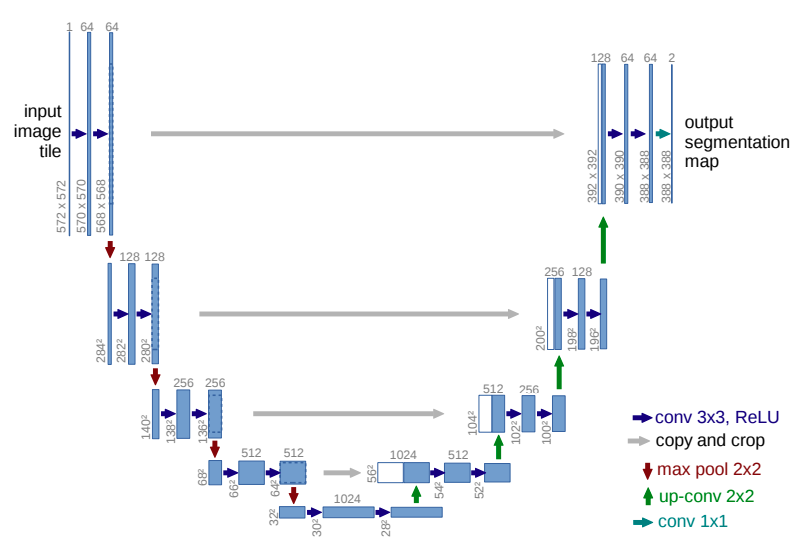

The implementation will cover the following steps:

* Defining the double convolution block
* Implementing the encoder with downsampling
* Implementing the decoder with skip connections and upsampling
* Finalizing the U-Net architecture

Double Convolution Block - It consists of 3*3 cnn blocks with relu and batchnorm and all set repeated twice. The block is used multiple times in both encoder and decoder for feature extraction and upscaling respectively.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [15]:
class DoubleConvBlock(nn.Module):
    """
    A convolutional block in the UNet architecture.
    This block consists of two convolutional layers with batch
        normalization followed by a ReLU activation function
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super(DoubleConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        op = self.conv(x)
        return op

Encoder Block - that downsamples the input image and extracts its features. It consists of a series of double convolution blocks followed by max pooling layers.

In [21]:
class Encoder(nn.Module):
    """
    The encoder part of the UNet architecture.
    This consists of a series of convolutional blocks followed by
                maxpooling operations
    """

    def __init__(self, channels):
        super(Encoder, self).__init__()
        self.encoder_blocks = nn.ModuleList()

        for i in range(len(channels) - 1):
            self.encoder_blocks.append(DoubleConvBlock(channels[i], channels[i + 1]))

            # Add a max pooling layer after each convolutional block except the last one
            if i < len(channels) - 2:
                self.encoder_blocks.append(nn.MaxPool2d(2))

    def forward(self, x):
        encoder_features = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)

            # Save the output of each convolutional block
            if isinstance(encoder_block, DoubleConvBlock):
                encoder_features.append(x)

        return encoder_features

Decoder Block-  upsamples the feature maps and combines them with the corresponding feature maps from the encoder to produce the final segmentation map. It consists of a series of transposed convolutional layers followed by concatenation with the corresponding feature maps from the encoder, and double convolution blocks to process the combined feature

In [22]:
class Decoder(nn.Module):
    """
    The decoder part of the UNet architecture.
    This consists of a series of convolutional blocks with decreasing number of channels.
    """

    def __init__(self, channels):
        super(Decoder, self).__init__()
        self.decoder_blocks = nn.ModuleList()

        # Add a upconvolutional followed by a double convolutional block for each level
        for i in range(len(channels) - 1):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
            )
            self.decoder_blocks.append(DoubleConvBlock(channels[i], channels[i + 1]))

    def _center_crop(self, feature, target_size):
        """Crops the input tensor to the target size."""
        _, _, H, W = target_size.shape
        _, _, h, w = feature.shape

        # Calculate the starting indices for the crop
        h_start = (h - H) // 2
        w_start = (w - W) // 2

        # Crop and returns the tensor
        return feature[:, :, h_start : h_start + H, w_start : w_start + W]

    def forward(self, x, encoder_features):
        for i, decoder_block in enumerate(self.decoder_blocks):
            # concatenate the output of the encoder with decoder
            if isinstance(decoder_block, DoubleConvBlock):
                encoder_feature = self._center_crop(encoder_features[i // 2], x)
                x = torch.cat([x, encoder_feature], dim=1)

            x = decoder_block(x)

        return x

Final Unet 

In [23]:
from typing import List

In [24]:
class UNet(nn.Module):
    """The UNet architecture.

    Args:
        out_channels (int): The number of output channels.
        channels (List[int]): A list of channels for convolutionals block.

    Example:
        >>> model = UNet(channels=[3, 64, 128, 256, 512], out_channels=1)
    """

    def __init__(
        self,
        channels: List[int],
        out_channels: int,
    ) -> None:
        super(UNet, self).__init__()
        self.rev_channels = channels[::-1]
        self.encoder = Encoder(channels)
        self.decoder = Decoder(self.rev_channels[:-1])
        self.output = nn.Conv2d(channels[1], out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the UNet architecture."""
        encoder_features = self.encoder(x)[::-1]
        x = self.decoder(encoder_features[0], encoder_features[1:])
        x = self.output(x)
        return x

In [25]:
# test the model
model = UNet(channels=[3, 64, 128, 256, 512, 1024], out_channels=1)

In [26]:
# input tensor
x = torch.randn(1, 3, 572, 572)
y = model(x)
print(y.shape) #-> torch.Size([1, 1, 388, 388])

RuntimeError: non-positive stride is not supported